# Introduction

One way the predictive capability of an OLS model can be hampered is by overfitting the training set data. When training on such a sample, a model can become overfit when it uses patterns and relationships found within the sample. 

Ridge gives a predictive model with **high variance** (parameter predictions vary greatly from sample to sample) and **low bias** (error introduced by the modelling technique), which is sub-optimal in its capabilities. It can be achieved through biasing parameter predictions towards zero (shrinkage). Ridge Regression (also known as Tikhonov regularization or $L_2$-regularization) achieves this shrinkage of the OLS predictions through the addition of an $L_2$ penalty to the loss function. 

# Algorithm

#### Deriving the Ridge Estimator

The Ridge loss function is similar to the OLS loss function but with the addition of an $L_2$ penalty:

$$ L(\mathbf{\beta}) =  \|\mathbf{y} - \mathbf{X}\mathbf{\beta}\|_2^2 + \lambda\|\mathbf{\beta}\|_2^2 \: \: \: \text{ with tuning parameter $\lambda \geq 0$} $$

The Ridge problem is also formalized as a least squares optimization problem: 

$$ \hat{\mathbf{\beta}} = \arg\min_{\mathbf{\beta}}  L(\mathbf{\beta}) = \arg\min_{\mathbf{\beta}} \|\mathbf{y}-\mathbf{X}\mathbf{\beta} \|_{2}^{2} + \lambda\|\mathbf{\beta}\|_2^2 $$

A closed-form solution can be analytically derived for the Ridge estimator similarly to the OLS case:

$$ {\hat {\beta }}=(\mathbf {X} ^{\mathsf {T}}\mathbf {X} +\lambda \mathbf {I} )^{-1}\mathbf {X} ^{\mathsf {T}}\mathbf {y} $$

This estimator can be shown to be unique similarly to the OLS case. First, the Hessian matrix is computed:

$$\mathbf{H} = 2\mathbf{X}^T\mathbf{X} + 2 \lambda \mathbf {I}$$

Next, this matrix is shown to be positive definite, implying strong convexity, as:

$$ \mathbf{\beta}^T (\mathbf{X}^T\mathbf{X} + \lambda \mathbf {I})\mathbf{\beta} = (\mathbf{X}\mathbf{\beta})\mathbf{X}\mathbf{\beta} + \lambda \mathbf{\beta}^T\mathbf{\beta} = \|\mathbf{X}\mathbf{\beta}\|_2^2 + \lambda \|\mathbf{\beta}\|_2^2 \succ 0 \: \: \: \forall \:\:\:  \mathbf{\beta} \neq \mathbf{0}$$

Establishing that the Ridge loss function is strongly convex implies that the Ridge estimator is the unique minimizer to the Ridge problem (10)

Note: $\lambda = 0$ produces the OLS estimate. Furthermore, features should be centered and scaled to unit variance to enable fair parameter shrinkage.

#### Adding an Intercept Term

To obtain an intercept term for the Ridge case, data augmentation is utilized again resulting in the following optimization problem which can be solved for the corresponding estimator:

\begin{align}
\begin{bmatrix}
    \hat{\beta}_0\\
    \hat{\mathbf{\beta}}\\
\end{bmatrix}
&=
\arg\min_{\beta_0,\beta} \left\Vert \begin{bmatrix}\mathbf{Y} \\ 0 \end{bmatrix}-\begin{bmatrix} \mathbf{1_n} & \mathbf{X} \\
                                                            0 & \lambda \cdot \mathbf{I} \end{bmatrix}\begin{bmatrix}
    \beta_0\\
    \mathbf{\beta}\\
\end{bmatrix}\right\Vert^2 _2
\end{align}

# Class

In [1]:
import numpy as np

class RidgeRegression:
    
    def __init__(self, learning_rate= 0.01, n_iters= 1000, lambda_r= 1):
        self.lr = learning_rate
        self.iterations = n_iters
        self.lambda_r = lambda_r
        self.theta = None
        self.bias = None

    def fit(self, X, y):
        n_samples, n_features = X.shape
        self.theta = np.random.random_sample(n_features)
        self.bias = np.random.random_sample()
        loss = []

        for _ in range(self.iterations):
            linear_model = X @ self.theta + self.bias
            d_theta = (1 / n_samples) * ( -(2 * (X.T @ (y - linear_model))) + (2 * self.lambda_r * self.theta))
            d_bias = (1 / n_samples) * (- 2 * np.sum(y - linear_model))
            self.theta -= self.lr * d_theta
            self.bias -= self.lr * d_bias
            loss.append(self._calculate_cost(y, linear_model, self.lambda_r, self.theta))
        self.loss = loss

    def predict(self, X):
        return X @ self.theta + self.bias
    
    def cost(self):
        return self.loss

    def _calculate_cost(self, y, z, lambda_r, theta):
        n_samples = y.shape[0] 
        ridge_loss = (1/n_samples) * np.sum(np.square(y - z)) + (0.5 * lambda_r * np.sum(np.square(theta)))
        return np.sqrt(ridge_loss) 

# Example

In [2]:
import pandas as pd
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def my_plot(cost):
    iterations = [i for i in range(1, 1001)]
    fig, ax = plt.subplots()
    ax.plot(iterations, cost, color='red')
    ax.set_xlabel('Iterations')
    ax.set_ylabel('Cost')
    ax.set_title('Cost vs Iterations')
    
def surface_plot(X, y, prediction, degree):
    fig = plt.figure(figsize=[30, 50])
    ax = fig.add_subplot(5, 2, degree, projection='3d')
    ax.scatter(X[:,0], X[:,1], y, zdir='z', s=20, c='#9467bd', depthshade=True)
    Y_plot = np.asarray(prediction)
    X = np.asarray(X)
    ax.plot_trisurf(X[:, 0], X[:, 1], Y_plot, cmap = 'viridis')
    ax.set_xlabel('$Age$', fontsize=10, rotation=150)
    ax.set_ylabel('$BMI$', fontsize=10, rotation=150)
    ax.set_zlabel('$Insurance$', fontsize=10, rotation=60)
    ax.set_title('Degree: ' + str(degree), fontsize=20)
    plt.show()

## Input data

In [3]:
data = pd.read_csv('../data/insurance.txt')
from sklearn.preprocessing import PolynomialFeatures
poly = PolynomialFeatures(4, include_bias= False)
X = data.iloc[:, :3]
X = poly.fit_transform(X)
X = (X - X.mean(axis= 0)) / X.std(axis= 0)
y = data.iloc[:, 3]

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y)
y_train = y_train.to_numpy()
y_test = y_test.to_numpy()

In [4]:
ridge = RidgeRegression(learning_rate= 0.01, n_iters= 1000, lambda_r= 1)
ridge.fit(X_train, y_train)
y_predicted_r = ridge.predict(X_train) 
cost_ridge = ridge.cost()

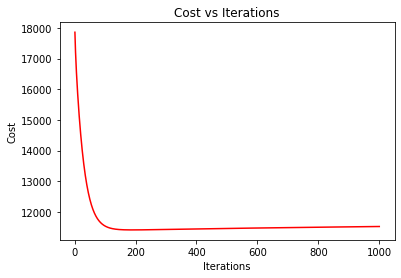

In [5]:
my_plot(cost_ridge)

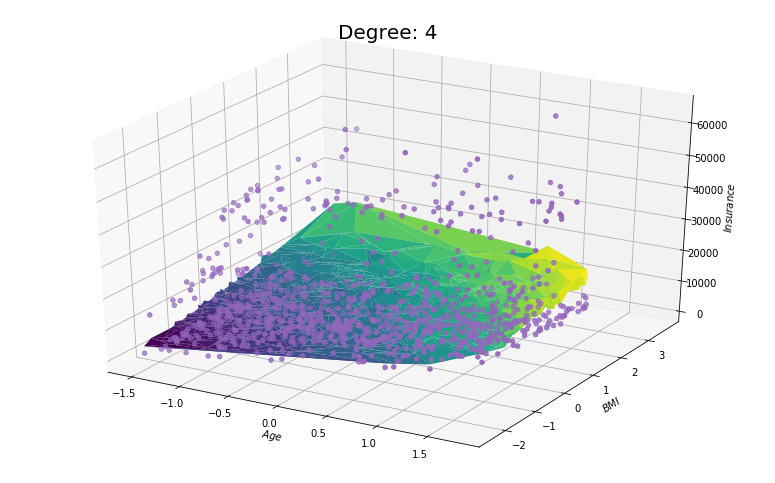

In [6]:
surface_plot(X_train, y_train, y_predicted_r, 4)